# Reinforcement Learning

Reinforcement learning is one of three basic machine learning paradigms, alongside supervised learning and unsupervised learning.

If you never heard of it, it's all good: albeit being a very old set of techniques (as pretty much everything in machine learning), it has only been recently explored and developed. A famous application of reinforcement learning is AlphaGo (albeit it was only used to improve the base algorithm).

*Reinforcement learning (RL) is concerned with how software agents ought to take actions in an environment in order to maximize the notion of cumulative reward.*

In simple words, we have an agent and we ask it to take actions (decide "the best" across a preselected set) and received a positive or negative rewards from the environment: once the reward is received, the agent will start to optimise its own behaviour to maximize the reward over time.

![RL](./mathworks-reinforcement-learning-fig1-543.jpg "RL")

## Multi Armed Bandit

Multi Armed Bandit is the simplest way to solve a reinforcement learning problem: in this scenario we have deterministic actions and unknown reward distributions; we aim to find the best sequence of actions that will maximize the total reward.

The problem can be easily visualised when we think about N slot machines (deterministic actions) and our attempt to pull the levers in an order that gives us the maximum won amount.

![MAB](./multi-armed-octopus.jpg "MAB")

Let's start coding...

In [1]:
import math

In [2]:
import numpy as np

import matplotlib.pyplot as plt
#
# makes charts prettier but slower...
# import seaborn as sns
#
# %matplotlib notebook
#
cmap = plt.get_cmap("tab10", 24)

In [3]:
def _argmax(items):
    val_max = -1
    idx_max = 0
    for idx, val in enumerate(items):
        if val > val_max:
            val_max = val
            idx_max = idx
    
    return idx_max

In [4]:
class Experiment:
    def __init__(self, agent, environment, name):
        self._agent = agent
        self._environment = environment
        self._name = name
        
        self._iters = None
        self._ks = []
        self._rewards = []
        self._regrets = []
    
    def run(self, iters):
        self._iters = iters
        for _ in range(iters):
            # core algorithm
            k = self._agent.get_k()# v1 or v2  
            reward = self._environment.compute_reward(k)

            # track metrics...
            self._ks.append(k)
            self._rewards.append(reward)
            
            probabilities = self._agent.get_probabilities()
            self._regrets.append(max(probabilities) - probabilities[k])
            
            # update agent
            self._agent.update(k, reward)
    
    @property
    def agent(self):
        return self._agent
    
    @property
    def name(self):
        return self._name

In [5]:
# plot experiment outcome...
def plot_experiment(experiment):
    x = np.arange(0, len(experiment._ks))

    plt.figure(figsize=(20, experiment.agent._k))
    plt.scatter(x, experiment._ks, c=experiment._ks, marker=".", alpha=0.5, cmap=cmap)
    plt.title(experiment.name, fontsize=16, fontweight="bold")
    plt.xlabel("Trials", fontsize=16, fontweight="bold")
    plt.ylabel("Actions", fontsize=16, fontweight="bold")
    
    plt.ylim(-0.5, experiment.agent._k - 0.5)
    plt.yticks(experiment._ks)
    
    plt.gca().invert_yaxis()
#     plt.colorbar()

    plt.show()

In [6]:
# Binary Environment: you either win or loose... 

class Environment:
    def __init__(self, payouts):
        self._payouts = payouts
        
    def compute_reward(self, k):
        return np.random.binomial(1, p=self._payouts[k])

In [7]:
# classic A/B testing... one version is clearly better performing than the other...

# PAYOUTS = [0.4, 0.2]

In [8]:
# A/B with a not-so-much clear winner
# 
# In this scenario, a long time might be required to find
# a statistically significant result (do you know statistical significance?)

# PAYOUTS = [0.2, 0.25]

In [9]:
#
# Multiple choices with a clear winner and a close second
#

# PAYOUTS = [0.35, 0.2, 0.1, 0.4, 0.1]

In [10]:
#
# More choices... can you give some random numbers please?
#

PAYOUTS = [0.1, 0.25, 0.3, 0.2, 0.156, 0.33, 0.134, 0.275, 0.29, 0.17]

In [11]:
N_TRIALS = 2500

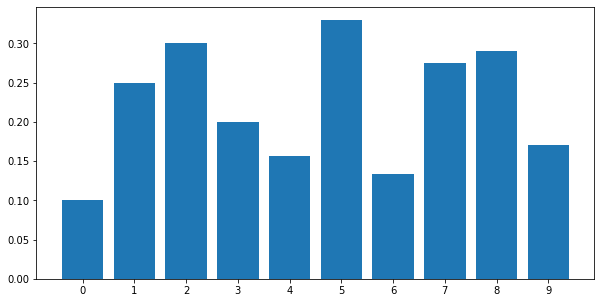

In [12]:
plt.figure(figsize=(10, 5))
plt.xticks(range(len(PAYOUTS)))
plt.bar(list(range(len(PAYOUTS))), PAYOUTS)
plt.show()

## Sampler (or Agent)

In [13]:
class RandomAgent:
    def __init__(self, k):
        self._k = k
        self._a = [0] * k
        self._b = [0] * k
        self._theta = [0.0] * k

    def get_k(self):
        return np.random.choice(self._k)
    
    def update(self, k, reward):
        # I am updating _a and _b, but in actual fact
        # the Random Agent is not learning any probability anyway
        self._a[k] += reward
        self._b[k] += 1
        self._theta[k] = float(self._a[k]) / self._b[k]
        
    def get_probabilities(self):
        return self._theta

In [14]:
rnd_exp = Experiment(
    name='random_sampler',
    agent=RandomAgent(len(PAYOUTS)),
    environment=Environment(payouts=PAYOUTS))

In [15]:
rnd_exp.run(N_TRIALS)

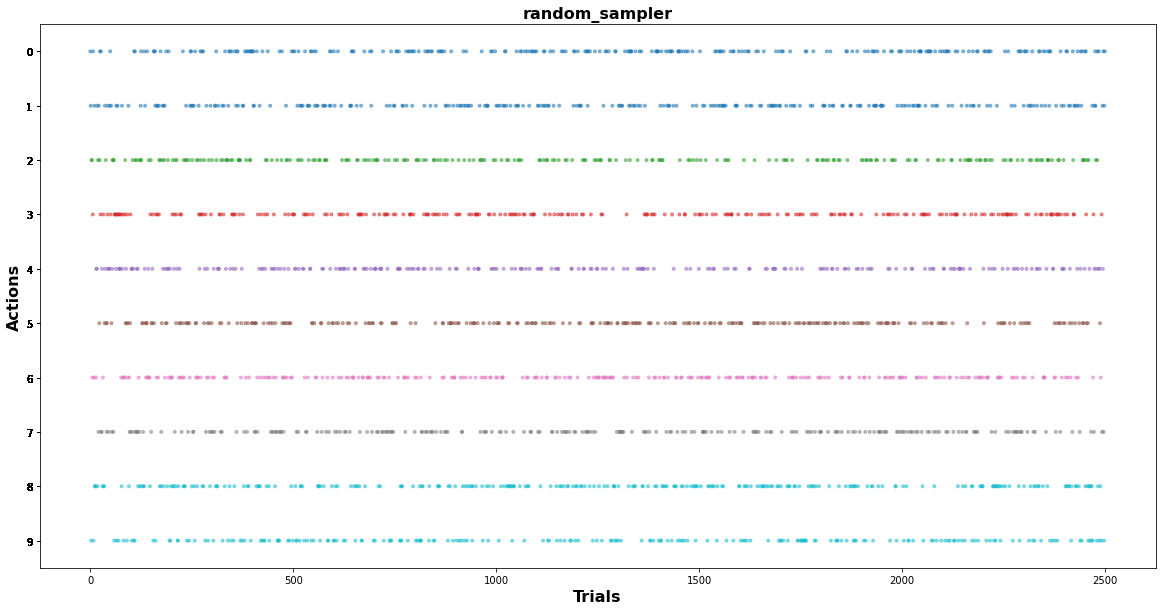

In [16]:
plot_experiment(rnd_exp)

In [17]:
rnd_exp.agent.get_probabilities()

[0.09266409266409266,
 0.23412698412698413,
 0.26639344262295084,
 0.21428571428571427,
 0.15767634854771784,
 0.34545454545454546,
 0.1449814126394052,
 0.26582278481012656,
 0.25384615384615383,
 0.1990521327014218]

The *Random Sampler* is the simplest way of choosing which "slot machine" to play at every single time, however it doesn't optimize the reward. This strategy is very similar to how a classic A/B test is performed, where the outcome of the experiment is measured at the end (probability of success for each option).

A multi-armed bandit strategy hinges on two phases:
- exploration
- exploitation

Different agents (or *sampler*, or *strategy*) have different ways of interleaving these two phases.

The simplest way to optimise the reward is to "explore" for a bit the environment, and then use the action with the highest probability of success. The name of this agent is `Epsilon Greedy`.

In [18]:
class EGreedyAgent:
    def __init__(self, k, eps, th):
        self._k = k
        self._eps = eps
        self._th = th
        self._call_count = 0
        # sum of reward
        self._a = [0] * k
        # count of pulls
        self._b = [0] * k
        self._theta = [0.0] * k
        
    def get_k(self):
        if self._call_count < self._th:
            k = np.random.choice(self._k)
            self._call_count += 1
        else:
            k = _argmax(self._theta)
            
        # with 1 - e probability take a random sample (explore) otherwise exploit
        if np.random.uniform(0, 1) > (1.0 - self._eps):
            return np.random.choice(self._k)
        else:
            return k
    
    def update(self, k, reward):
        self._a[k] += reward
        self._b[k] += 1
        self._theta[k] = float(self._a[k]) / self._b[k]
        
    def get_probabilities(self):
        return self._theta

In [19]:
eg_exp = Experiment(
    name='e_greedy_sampler',
    agent=EGreedyAgent(len(PAYOUTS), eps=0.25, th=250),
    environment=Environment(payouts=PAYOUTS))

In [20]:
eg_exp.run(N_TRIALS)

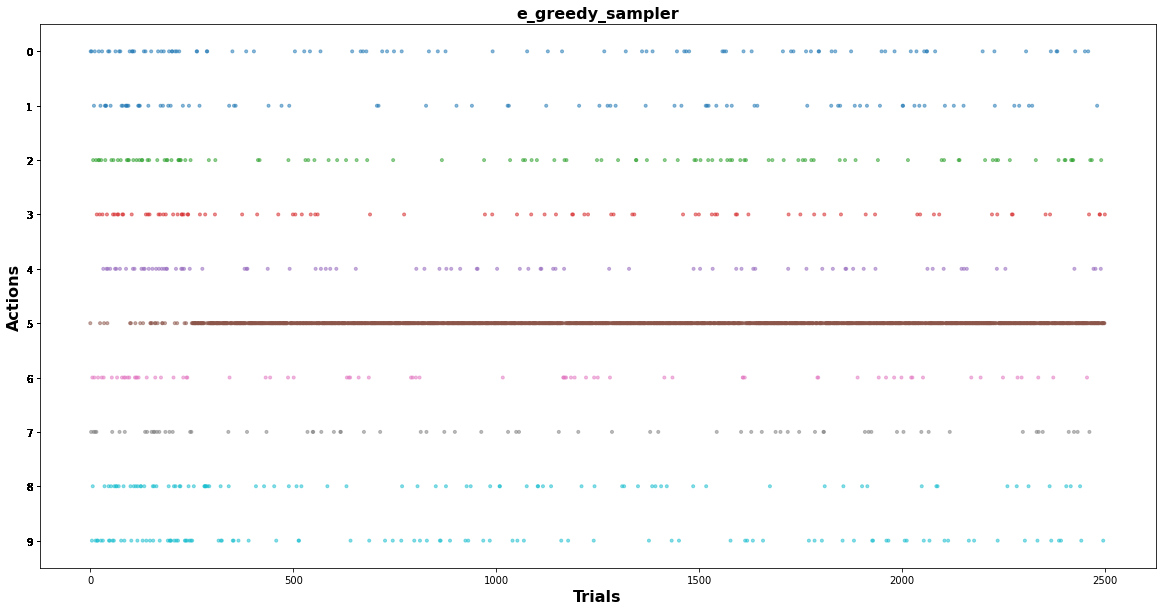

In [21]:
plot_experiment(eg_exp)

In [22]:
eg_exp.agent.get_probabilities()

[0.09574468085106383,
 0.21333333333333335,
 0.2803738317757009,
 0.26506024096385544,
 0.17857142857142858,
 0.3413932066781808,
 0.18309859154929578,
 0.29577464788732394,
 0.2682926829268293,
 0.22916666666666666]

The `e` parameter defines, after the initial phase, how often the Agent should try "something different": the larger the value, the smaller will be the exploration. Theoretically that decreases the total reward too.

Two other samplers are very famous too (plenty others exists, check wikipedia for more): 
- Upper Confidence Bound (many variants) - https://banditalgs.com/2016/09/18/the-upper-confidence-bound-algorithm/
- Thompson Sampler

In [23]:
# "1" because the upper confidence bound is dampened by a time component, instead then a constant
# factor as in the standard UCB method
# 
# The idea of the algorithm is to add a "bonus" to each action which is inverse proportion of
# how often it has been used before. This allows combinations that haven't been exploited (because
# less performing of the best) to be explored "sometimes".
#
# If we change the calculation of the average from a total running average to a weighted running average
# we have a new algorithm called Exp3 (https://jeremykun.com/2013/11/08/adversarial-bandits-and-the-exp3-algorithm/)
#
# Sometimes algorithms that look at close proximity history instead of their total one react better in changes
# of the environment

class UCB1:    
    def __init__(self, k, c):
        self._k = k
        self._c = c
        
        # average reward
        self._a = [0] * k
        # count
        self._b = [0] * k

    def get_k(self):
        # try all the combinations at least once...
        for k, b in enumerate(self._b):
            if b == 0:
                return k
        
        ucb = [0.0] * self._k
        b_total = sum(self._b)
        for k in range(self._k):
            bonus = math.sqrt((2.0 * math.log(b_total)) / self._b[k])
            # mean + bonus
            ucb[k] = self._a[k] + self._c * bonus

        return _argmax(ucb)

    def update(self, k, reward):
        self._b[k] += 1
        
        # compute (online) average << very neat trick!
        # ref: https://nestedsoftware.com/2018/03/20/calculating-a-moving-average-on-streaming-data-5a7k.22879.html
        self._a[k] = self._a[k] + (reward - self._a[k]) / self._b[k]

    def get_probabilities(self):
        return self._a

In [24]:
ucb_exp = Experiment(
    name='UCB1_sampler',
    agent=UCB1(len(PAYOUTS), c=0.66),
    environment=Environment(payouts=PAYOUTS))

In [25]:
ucb_exp.run(N_TRIALS)

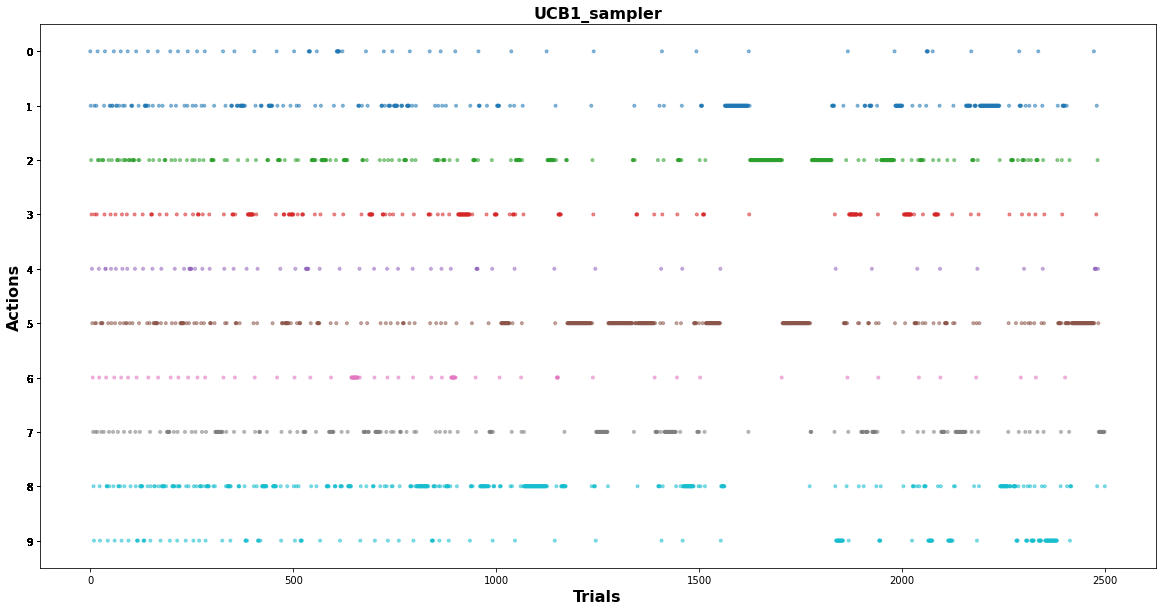

In [26]:
plot_experiment(ucb_exp)

In [27]:
ucb_exp.agent.get_probabilities()  # average for each k

[0.07017543859649124,
 0.27329192546583864,
 0.2860824742268041,
 0.24200913242009137,
 0.10144927536231886,
 0.30476190476190507,
 0.11842105263157902,
 0.2648083623693381,
 0.29,
 0.21019108280254784]

Another interesting sampler is the **Thompson Sampler**: the aim of this sampler is to find beta distribution parameters (success vs. failure counters) from historical data, and draw probabilities from these distributions when selecting the next action.

In [28]:
#
# ref: https://en.wikipedia.org/wiki/Beta_distribution
#

class ThompsonSampler:
    def __init__(self, k):
        self._k = k
        self._a = [1.0] * self._k
        self._b = [1.0] * self._k
        
    def get_k(self):
        theta_sample = [np.random.beta(self._a[k], self._b[k]) for k in range(self._k)]
        return _argmax(theta_sample)
    
    def update(self, k, reward):
        # update dist (a, b) = (a, b) + (r, 1 - r)
        self._a[k] += reward
        self._b[k] += 1.0 - reward
    
    def get_probabilities(self):
        return [self._a[k] / (self._a[k] + self._b[k]) for k in range(self._k)]

In [29]:
tm_exp = Experiment(
    name='thompson_sampler',
    agent=ThompsonSampler(len(PAYOUTS)),
    environment=Environment(payouts=PAYOUTS))

In [30]:
tm_exp.run(N_TRIALS)

In [31]:
tm_exp.agent.get_probabilities()

[0.14634146341463414,
 0.23529411764705882,
 0.2971887550200803,
 0.12903225806451613,
 0.10714285714285714,
 0.35215686274509805,
 0.12903225806451613,
 0.14285714285714285,
 0.2923497267759563,
 0.2247191011235955]

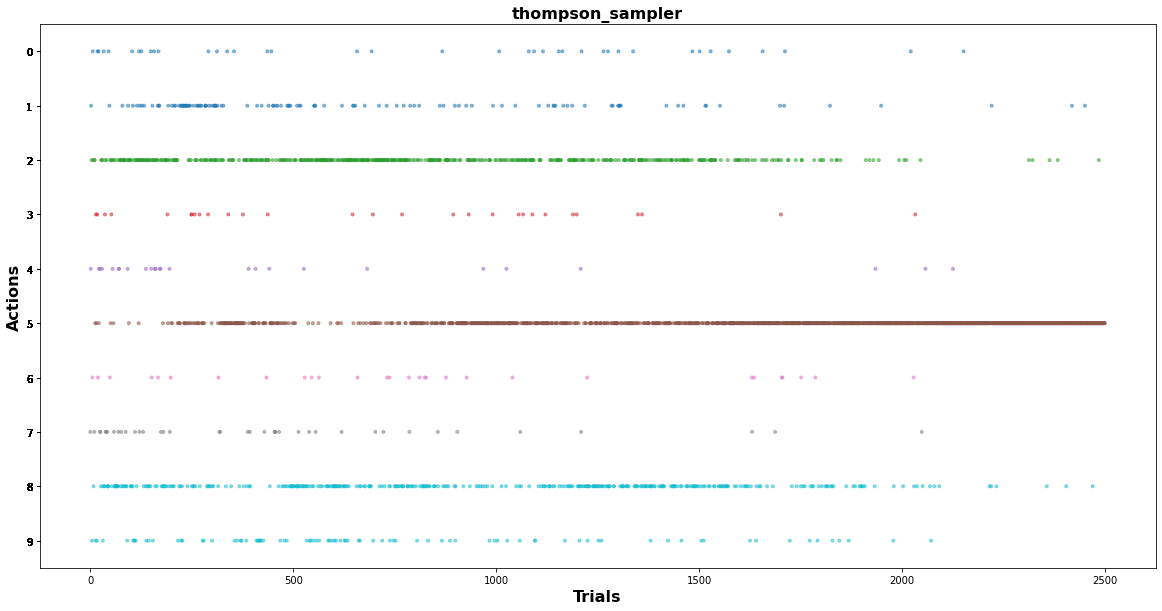

In [32]:
plot_experiment(tm_exp)

Thompson Agent is trying to fit a Beta distribution to the historical data. Those can be charts as well.

In [33]:
from scipy.stats import beta

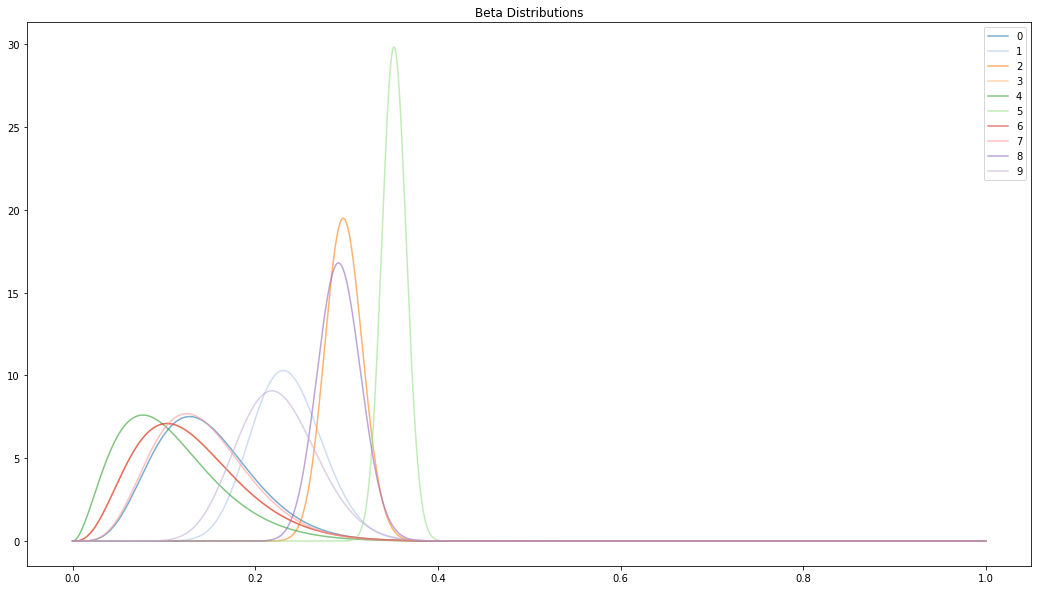

In [34]:
x = np.arange(0, 1, 0.0001)
cmap = list(plt.cm.tab20(list(range(tm_exp.agent._k))))

plt.figure(figsize=(18, 10))
for k in range(tm_exp.agent._k):
    pdf = beta(tm_exp.agent._a[k], tm_exp.agent._b[k]).pdf(x)
    plt.plot(x, pdf, c=cmap[k], label=k, alpha=.6)
plt.title("Beta Distributions")
plt.legend();

# Reward + Regret

In [35]:
experiments = [
    rnd_exp,
    eg_exp,
    ucb_exp,
    tm_exp
]

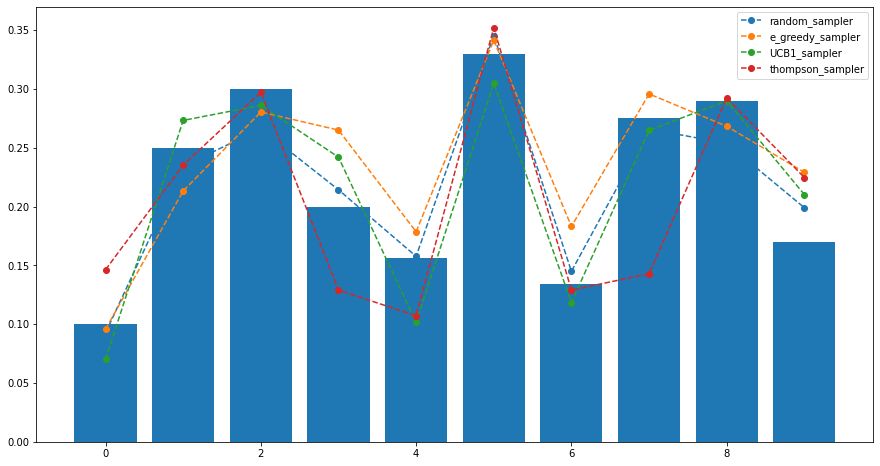

In [36]:
ks = list(range(len(PAYOUTS)))

plt.figure(figsize=(15, 8))
plt.bar(ks, PAYOUTS)
for experiment in experiments:
    plt.plot(ks, experiment.agent.get_probabilities(), label=experiment.name, linestyle='--', marker='o')
    
plt.legend()

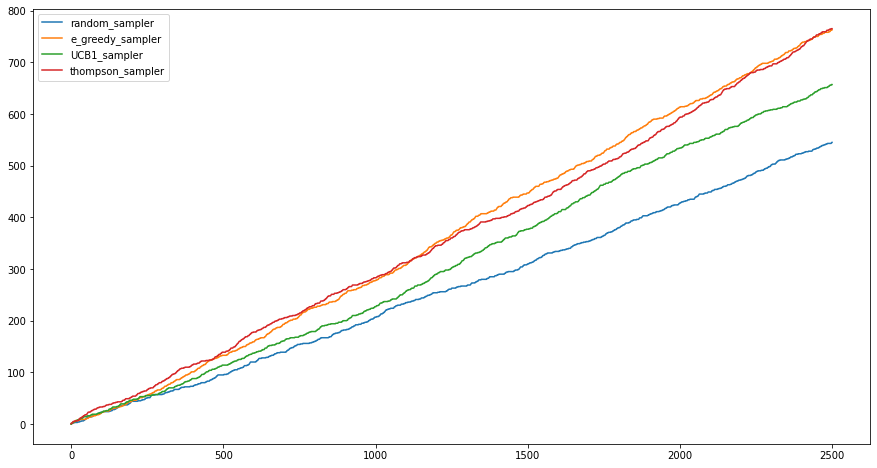

In [37]:
plt.figure(figsize=(15, 8))
for experiment in experiments:
    reward_cum = np.cumsum(experiment._rewards)
    plt.plot(reward_cum, label=experiment.name)
    
plt.legend()

In [38]:
# plt.figure(figsize=(15, 8))
# for experiment in experiments:
#     reward_cum = np.cumsum(experiment._rewards)
#     plt.plot(reward_cum / range(1, len(reward_cum) + 1), label=experiment.name)
    
# plt.yscale('log') 
# plt.legend()

Next chart: cumulative probability of selecting the best arm at time t. Ideally, "smarter" agents should converge towards an higher cumulative value.

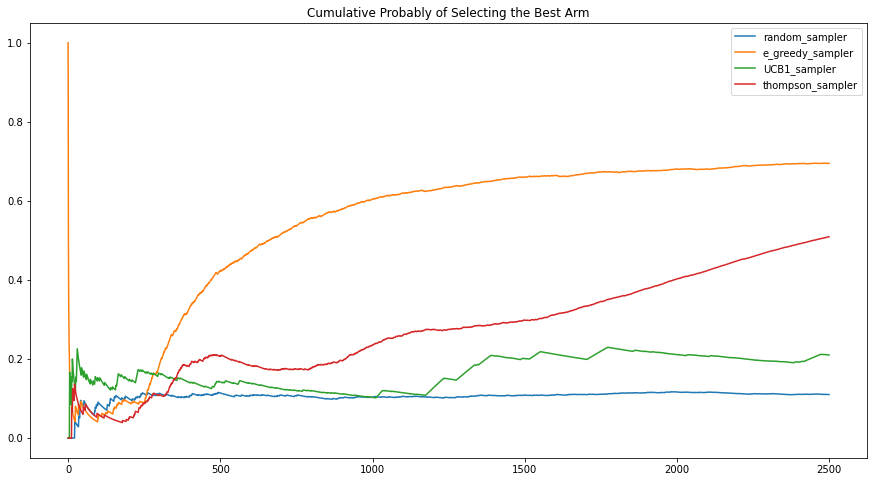

In [39]:
plt.figure(figsize=(15, 8))
best_k = _argmax(PAYOUTS)
for experiment in experiments:
    hits = [1 if k == best_k else 0 for k in experiment._ks]
    hits_cum = np.cumsum(hits)
    hits_prob = [float(a)/b for (a, b) in zip(hits_cum, range(1, len(hits) + 1))]
    plt.plot(hits_prob, label=experiment.name)
    
plt.title('Cumulative Probably of Selecting the Best Arm')
plt.legend()

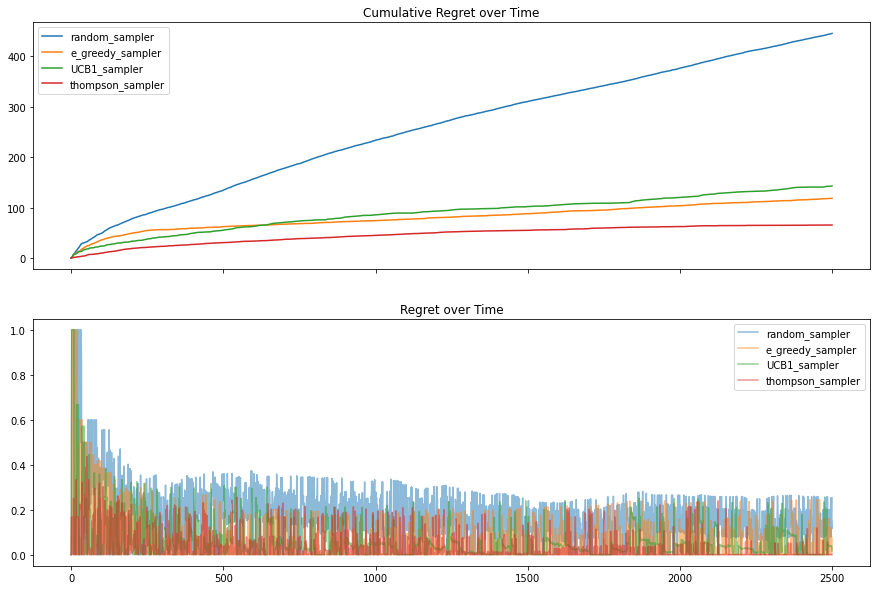

In [40]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(15, 10))
ax1.set_title('Cumulative Regret over Time')
ax2.set_title('Regret over Time')
for experiment in experiments:
    ax1.plot(np.cumsum(experiment._regrets), label=experiment.name)
    ax2.plot(experiment._regrets, label=experiment.name, alpha=0.5)
    
ax1.legend()
ax2.legend()

# Conclusions

What can this technique be used for?

- A/B testing (or even better, Multi Variate Testing MVT) in UX design
- Select the best creative for a marketing campaign
- Select the best article to put on the homepage of a newspaper
- Recommendation System (what is the best lender to show my customer? :-) )
- Optimise routing in computer networks (i.e. network interface with lower packet loss, or network interface with the lower latency)
- Advanced Load Balancing (as above)
- ... (many others -- see links below for some ideas)

When additional information is available about the environment, this technique can be extended to incorporate additional features, becoming *contextual* (see link below)

Question: **how would you deal with the fact that in many real-world system the reward is not immediately known?** (delayed feedback)

# Additional Material

- https://towardsdatascience.com/solving-multiarmed-bandits-a-comparison-of-epsilon-greedy-and-thompson-sampling-d97167ca9a50
- https://towardsdatascience.com/solving-the-multi-armed-bandit-problem-b72de40db97c
- https://www.dynamicyield.com/lesson/contextual-bandit-optimization/ << MAB with Context
- https://en.wikipedia.org/wiki/Multi-armed_bandit
- https://www.optimizely.com/uk/optimization-glossary/multi-armed-bandit/ << UX design
- https://lilianweng.github.io/lil-log/2018/01/23/the-multi-armed-bandit-problem-and-its-solutions.html (and associated code https://github.com/lilianweng/multi-armed-bandit)
- http://karpathy.github.io/2016/05/31/rl/
- https://towardsdatascience.com/the-upper-confidence-bound-ucb-bandit-algorithm-c05c2bf4c13f
- https://docs.microsoft.com/en-us/archive/msdn-magazine/2019/august/test-run-the-ucb1-algorithm-for-multi-armed-bandit-problems
- https://towardsdatascience.com/comparing-multi-armed-bandit-algorithms-on-marketing-use-cases-8de62a851831 << marketing
- https://towardsdatascience.com/multi-armed-bandits-ucb-algorithm-fa7861417d8c
- https://github.com/johnmyleswhite/BanditsBook